In [28]:
import numpy as np
import os
from Utils.utilities import *
import h5py
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
#from models.cnn2d_lstm import CNN2D_LSTM_Net
from models.cnn1d_lstm import CNN_LSTM_Net
from models.tinny import TinyMEGNet, MEGNet
import random
import itertools
from copy import deepcopy

In [29]:
set_seed(42) 

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [31]:
# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

# Example usage for Intra-subject classification
intra_train_path = os.path.join(filepath, "Intra", "train")
intra_test_path = os.path.join(filepath, "Intra", "test")

# Load a small subset of files to test the function
# Downsample factor is set to 16 to speed up the process, CHANGE LATER!
train_raw, train_labels = load_h5_files(intra_train_path)
test_raw, test_labels = load_h5_files(intra_test_path)

train_data = normalize_meg_data(train_raw, downsample_factor=4)
test_data = normalize_meg_data(test_raw, downsample_factor=4)

Base filepath: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data


In [32]:
# Check training set size and distribution
print(f"Training samples: {len(train_data)}")
print(f"Training label distribution:")
for label in set(train_labels):
    count = train_labels.count(label)
    print(f"  {label}: {count}")

print(f"\nTest samples: {len(test_data)}")
print(f"Test label distribution:")
for label in set(test_labels):
    count = test_labels.count(label)
    print(f"  {label}: {count}")

Training samples: 32
Training label distribution:
  task_working: 8
  rest: 8
  task_motor: 8
  task_story: 8

Test samples: 8
Test label distribution:
  task_working: 2
  rest: 2
  task_motor: 2
  task_story: 2


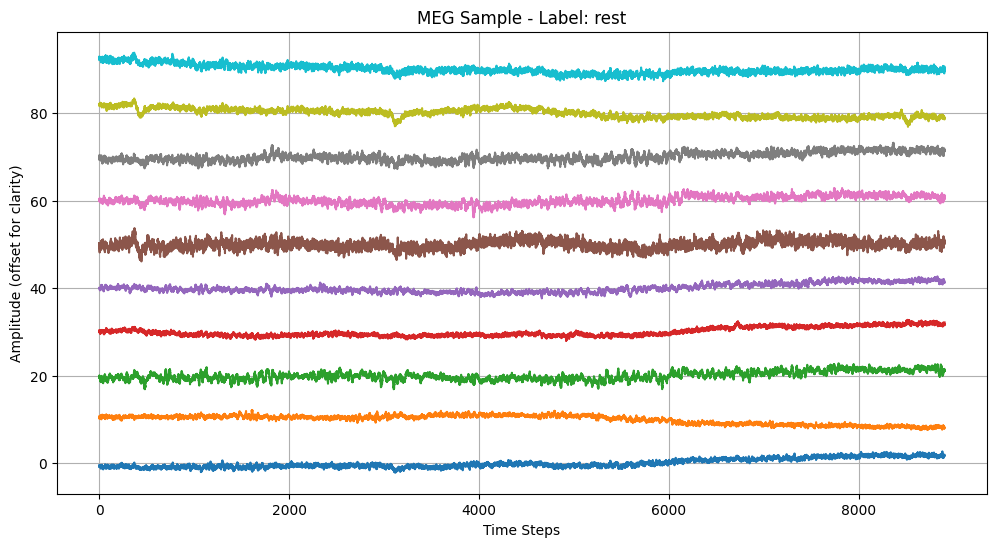

In [33]:
plot_meg_sample(train_data[0], train_labels[0])

In [34]:
# Standard class mapping for MEG tasks

LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

# TRAIN & RANDOM GRID SEARCH

## Model

In [35]:
class CNN2D_LSTM_Net(nn.Module):
    """
    A hybrid deep learning model for MEG classification.

    Architecture:
    1. 2D CNN layers: Learn local spatiotemporal features from MEG sensor data.
    2. LSTM layer: Captures global temporal dependencies across time.
    3. Fully connected layers: Map learned features to class probabilities.
    """

    def __init__(self, num_classes=4, input_sensors=248, input_time_steps=2227,
                 lstm_hidden_size=64, num_lstm_layers=2, dropout=0.3,
                 cnn_kernel_1=(3, 15), cnn_stride_1=(2, 4),
                 cnn_kernel_2=(2, 4), cnn_stride_2=(2, 3),
                 filters_1=32, filters_2=64):
        super(CNN2D_LSTM_Net, self).__init__()

        self.input_sensors = input_sensors
        self.input_time_steps = input_time_steps

        # === Step 1: 2D CNN over (sensors x time) ===
        self.cnn = nn.Sequential(
            nn.Conv2d(1, filters_1, kernel_size=cnn_kernel_1, stride=cnn_stride_1, padding=(2, 12)),
            nn.BatchNorm2d(filters_1),
            nn.ReLU(),
            nn.Dropout2d(dropout),

            nn.Conv2d(filters_1, filters_2, kernel_size=cnn_kernel_2, stride=cnn_stride_2, padding=(1, 7)),
            nn.BatchNorm2d(filters_2),
            nn.ReLU(),
            nn.Dropout2d(dropout)
        )

        # Auto-calculate CNN output size for LSTM
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_sensors, input_time_steps)
            cnn_out = self.cnn(dummy_input)
            _, cnn_channels, reduced_sensors, reduced_time = cnn_out.shape
            self.lstm_input_size = cnn_channels * reduced_sensors
            self.sequence_length = reduced_time

        # === Step 2: LSTM ===
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=True
        )

        # === Step 3: Classifier ===
        self.classifier = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, num_classes)
        )

        print(f"2D CNN + LSTM Net initialized:")
        print(f"  - LSTM input size: {self.lstm_input_size}")
        print(f"  - Sequence length: {self.sequence_length}")
        print(f"  - Parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn(x)  # (B, channels, sensors, time)
        x = x.permute(0, 3, 1, 2)  # (B, time, channels, sensors)
        x = x.contiguous().view(batch_size, self.sequence_length, -1)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # final time step
        return self.classifier(x)

## Analyze funct

In [36]:
from sklearn.metrics import confusion_matrix, f1_score


def analyze_cv_results(fold_results, all_histories, label_map):
    """Analyze cross-validation results"""

    print(f"\n{'='*60}")
    print(f"  CROSS-VALIDATION RESULTS SUMMARY")
    print(f"{'='*60}")

    # Extract accuracies
    best_accs = [result['best_val_acc'] for result in fold_results]
    final_accs = [result['final_val_acc'] for result in fold_results]

    # Summary statistics
    print(f"\nBest Validation Accuracies per Fold:")
    for i, acc in enumerate(best_accs):
        print(f"  Fold {i+1}: {acc:.4f} ({acc*100:.2f}%)")

    mean_accuracy = np.mean(best_accs)
    std_accuracy = np.std(best_accs)
    print(f"\nCross-Validation Summary:")
    print(f"  Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"  Best Fold: {np.max(best_accs):.4f}")
    print(f"  Worst Fold: {np.min(best_accs):.4f}")

    sys.stdout.flush()

    # Collect all predictions and true labels
    all_predictions = []
    all_true_labels = []
    for result in fold_results:
        all_predictions.extend(result['val_predictions'])
        all_true_labels.extend(result['val_true'])

    # Compute F1 Score (macro)
    macro_f1 = f1_score(all_true_labels, all_predictions, average='macro')
    hybrid_score = (macro_f1 + mean_accuracy) / 2

    print(f"\n  F1 Macro Score: {macro_f1:.4f}")
    print(f"  Hybrid Score (Avg of Accuracy and F1): {hybrid_score:.4f}")

    return mean_accuracy, std_accuracy, macro_f1, hybrid_score

## Random search Funct

In [37]:
# Random search function
def random_search(train_data, train_labels, LABEL_MAP, base_config, SEARCH_SPACE, model_class, cross_val_fn, analyze_fn, n_trials=10):
    results = []

    for trial in range(n_trials):
        trial_config = deepcopy(base_config)

        # Randomly sample parameters
        for param, choices in SEARCH_SPACE.items():
            trial_config[param] = random.choice(choices)

        print(f"\n🔍 Trial {trial+1}/{n_trials} - Params: {trial_config}")

        # Define model function
        def model_fn():
            return model_class(
                num_classes=trial_config["num_classes"],
                input_sensors=trial_config["input_sensors"],
                input_time_steps=trial_config["input_time_steps"],
                lstm_hidden_size=trial_config["lstm_hidden_size"],
                num_lstm_layers=trial_config["num_lstm_layers"],
                dropout=trial_config["dropout"],
                cnn_kernel_1=trial_config["cnn_kernel_1"],
                cnn_stride_1=trial_config["cnn_stride_1"],
                cnn_kernel_2=trial_config["cnn_kernel_2"],
                cnn_stride_2=trial_config["cnn_stride_2"],
                filters_1=trial_config["filters_1"],
                filters_2=trial_config["filters_2"]
            )

        # Run experiment
        fold_results, all_histories = cross_val_fn(
            all_data=train_data,
            all_labels=train_labels,
            label_map=LABEL_MAP,
            model_fn=model_fn,
            lr=trial_config["lr"],
            weight_decay=trial_config["weight_decay"],
            patience=trial_config["patience"],
            n_splits=trial_config["n_splits"],
            epochs=trial_config["epochs"],
            batch_size=trial_config["batch_size"],
            seed=trial_config["seed"]
        )

        # Analyze
        mean_acc, std_acc, f1, acc_f1_mean = analyze_fn(fold_results, all_histories, LABEL_MAP)
        results.append((trial_config, mean_acc, std_acc, f1, acc_f1_mean))

    # Sort by performance
    results.sort(key=lambda x: x[4], reverse=True)
    return results


In [38]:
# Define the parameter search space
SEARCH_SPACE = {
    "cnn_kernel_1": [(3, 15), (5, 15), (3, 7), (7,15)],
    "cnn_stride_1": [(2, 4), (1, 3)],
    "cnn_kernel_2": [(2, 4), (3, 5), (5, 7)],
    "cnn_stride_2": [(2, 3), (1, 2)],
    "lstm_hidden_size": [32, 64, 128],
    "num_lstm_layers": [2, 3],
    "dropout": [0.2, 0.3, 0.5],
    "filters_1": [16, 32, 64],   
    "filters_2": [32, 64, 128],  
    "lr": [1e-3, 5e-4],
    "weight_decay": [1e-4, 5e-4, 1e-5]
}

In [39]:
CONFIG = {
    # --- Model hyperparameters ---
    "num_classes": len(LABEL_MAP),
    "input_sensors": 248,
    "input_time_steps": train_data[0].shape[1],
    "lstm_hidden_size": 64,
    "num_lstm_layers": 2,
    "dropout": 0.3,    
    # --- Training hyperparameters ---
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "patience": 12,
    "epochs": 50,
    "batch_size": 4,
    "seed": 42,
    "n_splits": 4
}


In [40]:
search_results = random_search(
    train_data=train_data,
    train_labels=train_labels,
    LABEL_MAP=LABEL_MAP,
    base_config=CONFIG,
    SEARCH_SPACE=SEARCH_SPACE,
    model_class=CNN2D_LSTM_Net,
    cross_val_fn=cross_validation_experiment,
    analyze_fn=analyze_cv_results,
    n_trials= 50  # Or more
)




🔍 Trial 1/50 - Params: {'num_classes': 4, 'input_sensors': 248, 'input_time_steps': 8906, 'lstm_hidden_size': 32, 'num_lstm_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 1e-05, 'patience': 12, 'epochs': 50, 'batch_size': 4, 'seed': 42, 'n_splits': 4, 'cnn_kernel_1': (3, 15), 'cnn_stride_1': (2, 4), 'cnn_kernel_2': (5, 7), 'cnn_stride_2': (1, 2), 'filters_1': 64, 'filters_2': 32}

  CROSS-VALIDATION EXPERIMENT (4 folds)
Total samples: 32
Samples per fold - Train: ~24, Val: ~8

--- FOLD 1/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3936
  - Sequence length: 1119
  - Parameters: 1,118,468
Epoch  0: Train Acc=0.250, Val Acc=0.250, Val Loss=1.384
Epoch 10: Train Acc=0.833, Val Acc=0.750, Val Loss=1.030
Epoch 20: Train Acc=0.792, Val Acc=0.500, Val Loss=1.317
Early stopping at epoch 28
Fold 1 Best Val Accuracy: 0.8750

--- FOLD 2/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3936
  - Sequence length: 1119
  - Parameters: 1,118,468
Epoch  0: Train Acc=0.2

In [41]:
# Show best trials
for i, (cfg, acc, std, F1, acc_F1) in enumerate(search_results):
    print(f"Trial {i+1}: \nAcc/F1 (mean) = {acc_F1} \nAccuracy = {acc:.4f} ± {std:.4f}, F1 = {F1} \nConfig = {cfg}\n")
    print('----------------------')

Trial 1: 
Acc/F1 (mean) = 0.7087968200100553 
Accuracy = 0.7188 ± 0.0541, F1 = 0.6988436400201106 
Config = {'num_classes': 4, 'input_sensors': 248, 'input_time_steps': 8906, 'lstm_hidden_size': 32, 'num_lstm_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 1e-05, 'patience': 12, 'epochs': 50, 'batch_size': 4, 'seed': 42, 'n_splits': 4, 'cnn_kernel_1': (3, 15), 'cnn_stride_1': (2, 4), 'cnn_kernel_2': (5, 7), 'cnn_stride_2': (1, 2), 'filters_1': 64, 'filters_2': 32}

----------------------
Trial 2: 
Acc/F1 (mean) = 0.6738689299830604 
Accuracy = 0.7812 ± 0.0541, F1 = 0.5664878599661207 
Config = {'num_classes': 4, 'input_sensors': 248, 'input_time_steps': 8906, 'lstm_hidden_size': 32, 'num_lstm_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 1e-05, 'patience': 12, 'epochs': 50, 'batch_size': 4, 'seed': 42, 'n_splits': 4, 'cnn_kernel_1': (3, 15), 'cnn_stride_1': (2, 4), 'cnn_kernel_2': (5, 7), 'cnn_stride_2': (1, 2), 'filters_1': 64, 'filters_2': 32}

-------------------